# ADS4SJ Research Project 

Task: Working with datasets provided by CAHOOTS and CAD datasets to help answer research questions provided by DSCI 410. We, individually, select research questions that we are interested in researching for the Spring Term of 2024. This research project allows to be hands on cleaning data, analyzing in order to answer RQs, create vizualizations for a non-profit organization and give them insightful data that can improve their daily operations and help them become more aware of a certain observations. Also, write reports and conclusions of our find and how it is beneficial to others.

RQs: The research questions that I decided to investigate: **How well do the CAD and CAHOOTS call data line up?, What, if any, systematic differences exist?, and What, if any, occasional differences exist?**

## Data Cleaning Process

I chose to investigate the CAHOOTS datasets 2021-2022 and 2022-2023 (combined with concat) and CAD dataset from 2016-2023 to investigate the concordance between dispatch and cahoot records. First, I converted columns with date and time information to datetime format to compare the CAHOOTS and CAD datasets. I chose not to use the CAD dataset from 2022 since CAD 2016-2023 gave a wider range of time that can be observed.

In [1]:
import pandas as pd
import numpy as np
import datetime

# Given unclean data by CAD And CAHOOTS that will be deleted after presentation 
cad16_23 = pd.read_csv('call_data_from_CAD.csv') #1616829 rows by 12 columns
cahoot_og = pd.read_csv('call_data_from_CAHOOTS.csv') #19570 rows by 8 columns
cahoot_21_to_22 = pd.read_csv('call_data_from_CAHOOTS_2021_2022.csv') #47951 rows by 8 columns

In [2]:
# Combined Cahoot Datasets (Unclean)
cahoot_datasets = [cahoot_21_to_22, cahoot_og]
cahootdf = pd.concat(cahoot_datasets)

#cahootdf.head(5)

# Create a copy of Cahoots data to avoid modifying the original
cahootdf_copy = cahootdf.copy()

# Removal of NaNs in 'TimeOfCall' column
cahootdf_copy = cahootdf_copy.dropna(subset=['TimeOfCall'])

# Conversion of objects to strings in columns 'Date' and 'TimeOfCall'
cahootdf_copy.loc[:, 'Date'] = cahootdf_copy['Date'].astype(str)
cahootdf_copy.loc[:, 'TimeOfCall'] = cahootdf_copy['TimeOfCall'].astype(str)

# Stripping leading/trailing whitespace in 'Date' and 'TimeOfCall' columns
cahootdf_copy.loc[:, 'Date'] = cahootdf_copy['Date'].str.strip()
cahootdf_copy.loc[:, 'TimeOfCall'] = cahootdf_copy['TimeOfCall'].str.strip()

# Converting 'Date' and 'TimeOfCall' columns to datetime format
cahootdf_copy.loc[:, 'Date'] = pd.to_datetime(cahootdf_copy['Date'], errors='coerce').dt.strftime('%Y-%m-%d')
cahootdf_copy.loc[:, 'TimeOfCall'] = pd.to_datetime(cahootdf_copy['TimeOfCall'], format='%H:%M:%S', errors='coerce').dt.strftime('%H:%M:%S')

# Combining date and time columns
cahootdf_copy.loc[:, 'Datetime'] = pd.to_datetime(cahootdf_copy['Date'] + ' ' + cahootdf_copy['TimeOfCall'], errors='coerce')

# Handle errors (drop rows with invalid datetime)
cahootdf_copy = cahootdf_copy.dropna(subset=['Datetime'])

# Reorder columns to make 'Datetime' the first column
reorg_cols = ['Datetime'] + [col for col in cahootdf_copy.columns if col != 'Datetime']
cahootdf_copy = cahootdf_copy[reorg_cols]

# Setting 'Datetime' in chronological order
cahootdf_copy.sort_values(by='Datetime', inplace=True)

# Selecting columns to use (Dropping 'Date' and 'TimeOfCall'
columns_inuse = ['Datetime', 'Age', 'Gender', 'Race', 'City', 'Reason for Dispatch']
cahootdf_copy = cahootdf_copy[columns_inuse]

# Resetting index
cahootdf_copy.reset_index(drop=True, inplace=True)

# Printing copy of DataFrame (59589 rows)
cahootdf_copy

# Filtering to the city of Eugene (43744 rows)
#eug_cahootdf = cahootdf_copy[cahootdf_copy['City'] == 'Eugene']
#eug_cahootdf.reset_index(drop=True, inplace=True)

cahootdf_copy.head(0)

,Datetime,Age,Gender,Race,City,Reason for Dispatch


In [3]:
cad16_23
cad16_23.dtypes

Unnamed: 0                          int64
IncidentNumber                     object
Call_Created_Time                  object
Call_First_Dispatched_Time         object
Call_First_On_Scene                object
Call_Cleared                       object
Call_Zipcode                      float64
Beat                               object
Call_Source                        object
Call_Priority                      object
InitialIncidentTypeDescription     object
IsPrimary                           int64
PrimaryUnitCallSign                object
RespondingUnitCallSign             object
Unit_Dispatched_Time               object
Unit_OnScene_Time                  object
Unit_Cleared_Time                  object
Disposition                        object
dtype: object

In [4]:
# Creating a copy to avoid modifying original dataframe
cad16_23copy = cad16_23.copy()

# Columns I selected to use to analyze
cols_inuse = ['IncidentNumber', 'Call_Created_Time', 'Call_Zipcode', 
              'InitialIncidentTypeDescription', 'Call_Priority', 'IsPrimary', 'PrimaryUnitCallSign','RespondingUnitCallSign', 
              'Unit_Dispatched_Time','Disposition']

cad16_23copy = cad16_23copy[cols_inuse]

# Slicing to only have last 8 digits in Incident Number column
cad16_23copy.loc[:, 'IncidentNumber'] = cad16_23copy['IncidentNumber'].str[-8:]

# Conversion to strings of columns that I want to convert to datetime
cad16_23copy.loc[:, 'Call_Created_Time'] = cad16_23copy['Call_Created_Time'].astype(str)
cad16_23copy.loc[:, 'Unit_Dispatched_Time'] = cad16_23copy['Unit_Dispatched_Time'].astype(str)

# Stripping leading/trailing whitespace
cad16_23copy.loc[:, 'Call_Created_Time'] = cad16_23copy['Call_Created_Time'].str.strip()
cad16_23copy.loc[:, 'Unit_Dispatched_Time'] = cad16_23copy['Unit_Dispatched_Time'].str.strip()

# Changing Time columns to datetime format
cad16_23copy['Call_Created_Time'] = pd.to_datetime(cad16_23copy['Call_Created_Time'], errors='coerce')
cad16_23copy['Unit_Dispatched_Time'] = pd.to_datetime(cad16_23copy['Unit_Dispatched_Time'], errors='coerce')

# Sorting CAD 2016-2023 Data with CAHOOT Identifiers
cahoot_ids = ['3J79', '3J78', '3J77', '1J77', '4J79', '3J81', '3J76', '2J28', '2J29', 'CAHOT', 'CAHOOT']
cahoot_in_cad16_23 = cad16_23copy[
    (cad16_23copy["PrimaryUnitCallSign"].isin(cahoot_ids)) |
    (cad16_23copy["RespondingUnitCallSign"].isin(cahoot_ids))
]
# Sort 'Call_Created_Time' in chronological order
cahoot_in_cad16_23 = cahoot_in_cad16_23.sort_values(by='Call_Created_Time').reset_index(drop=True)

cahoot_in_cad16_23
# Creating a start date to use to filter for data visualization for 2021-2023
start_date = '2021-01-01'
cahoot_in_cad21_23 = cahoot_in_cad16_23[cahoot_in_cad16_23['Call_Created_Time'] >= start_date].copy()

# Display the filtered DataFrame
cahoot_in_cad21_23.reset_index(drop=True) # 31884 rows

cahoot_in_cad21_23.dtypes

IncidentNumber                            object
Call_Created_Time                 datetime64[ns]
Call_Zipcode                             float64
InitialIncidentTypeDescription            object
Call_Priority                             object
IsPrimary                                  int64
PrimaryUnitCallSign                       object
RespondingUnitCallSign                    object
Unit_Dispatched_Time              datetime64[ns]
Disposition                               object
dtype: object

In [5]:
#cahootdf_copy['Reason for Dispatch'].value_counts()

In [6]:
#cahoot_in_cad16_23['InitialIncidentTypeDescription'].value_counts()

In [7]:
#cahoot_in_cad21_23['InitialIncidentTypeDescription'].value_counts()

# Data Visualization

This section shows how I compare the 2 dataframes to analyze the similarities and differencies between them to get the result necessary for the research project.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


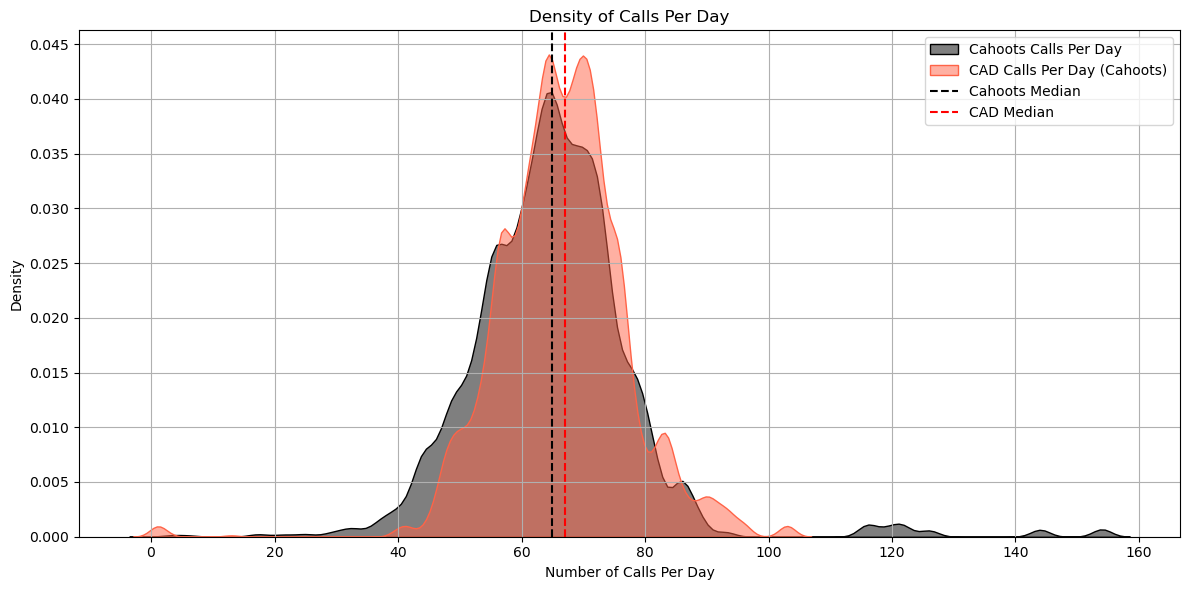

Mann-Whitney U test statistic: 847225099.5, p-value: 1.105064529886472e-160


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

# Create copies of the filtered dataframes
cahootdf_copy2 = cahootdf_copy.copy()
cahoot_in_cad21_23_copy = cahoot_in_cad21_23.copy()

# Add CCPD columns
cahootdf_copy2['Date'] = cahootdf_copy2['Datetime'].dt.date
cahoot_in_cad21_23_copy['Date'] = cahoot_in_cad21_23_copy['Call_Created_Time'].dt.date

# Calculate calls per day
cahootdf_copy2['CCPD'] = cahootdf_copy2.groupby('Date')['Datetime'].transform('count')
cahoot_in_cad21_23_copy['CCPD'] = cahoot_in_cad21_23_copy.groupby('Date')['Call_Created_Time'].transform('count')

# Drop rows with NaN values in CCPD to avoid issues in plotting
cahootdf_copy2 = cahootdf_copy2.dropna(subset=['CCPD'])
cahoot_in_cad21_23_copy = cahoot_in_cad21_23_copy.dropna(subset=['CCPD'])

# Extract CCPD values
ccpd_cahoot = cahootdf_copy2['CCPD']
ccpd_cad = cahoot_in_cad21_23_copy['CCPD']

# Calculate medians
median_cahoot = ccpd_cahoot.median()
median_cad = ccpd_cad.median()

# Plot density
plt.figure(figsize=(12, 6))
sns.kdeplot(ccpd_cahoot, label='Cahoots Calls Per Day', fill=True, common_norm=False, alpha=0.5, color='black')
sns.kdeplot(ccpd_cad, label='CAD Calls Per Day (Cahoots)', fill=True, common_norm=False, alpha=0.5, color='tomato')

# Add median lines
plt.axvline(median_cahoot, color='black', linestyle='--', linewidth=1.5, label='Cahoots Median')
plt.axvline(median_cad, color='red', linestyle='--', linewidth=1.5, label='CAD Median')

# Adjust y-axis to increment by 0.005
plt.yticks(np.arange(0, plt.gca().get_ylim()[1], 0.005))

plt.title('Density of Calls Per Day')
plt.xlabel('Number of Calls Per Day')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Perform Mann-Whitney U test (Wilcoxon rank-sum test)
stat, p_value = mannwhitneyu(ccpd_cahoot, ccpd_cad, alternative='two-sided')

# Print Mann-Whitney U test result
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p_value}")

In [9]:
# View the length of independent samples
print("Length of Cahoot Calls Per Day sample:", len(ccpd_cahoot))
print("Length of CAD Calls Per Day (Cahoot) sample:", len(ccpd_cad))

Length of Cahoot Calls Per Day sample: 59589
Length of CAD Calls Per Day (Cahoot) sample: 31884


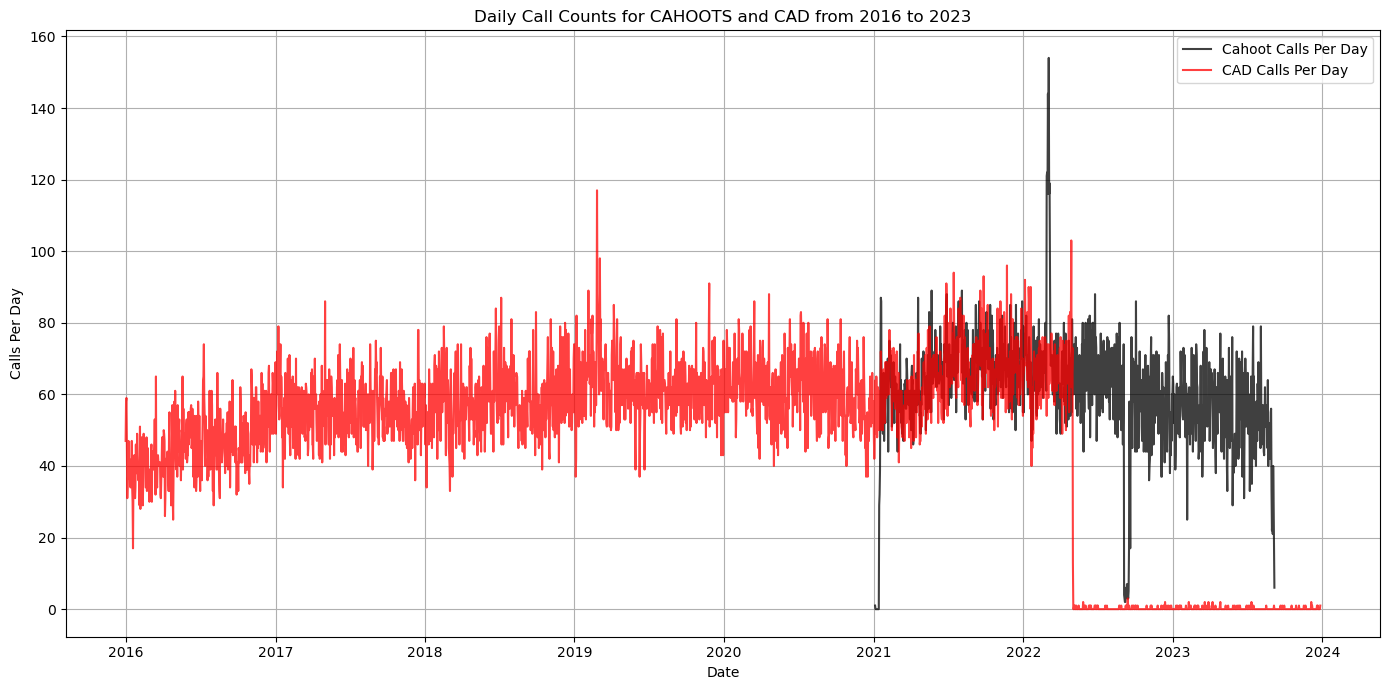

In [10]:
# Create copies of the dataframes for this analysis
cahoots_copy = cahootdf_copy.copy()
cad_copy = cahoot_in_cad16_23.copy()

# Ensure datetime columns are in the correct format
cahoots_copy['Datetime'] = pd.to_datetime(cahoots_copy['Datetime'], errors='coerce')
cad_copy['Call_Created_Time'] = pd.to_datetime(cad_copy['Call_Created_Time'], errors='coerce')

# Filter data for the period from 2016 to 2023
cahoots_copy = cahoots_copy[(cahoots_copy['Datetime'] >= '2016-01-01') & (cahoots_copy['Datetime'] <= '2023-12-31')]
cad_copy = cad_copy[(cad_copy['Call_Created_Time'] >= '2016-01-01') & (cad_copy['Call_Created_Time'] <= '2023-12-31')]

# Add CCPD columns
cahoots_copy['Date'] = cahoots_copy['Datetime'].dt.date
cad_copy['Date'] = cad_copy['Call_Created_Time'].dt.date

# Calculate calls per day
cahoots_daily_calls = cahoots_copy.groupby('Date').size().reset_index(name='CCPD')
cad_daily_calls = cad_copy.groupby('Date').size().reset_index(name='CCPD')

# Convert 'Date' back to datetime for resampling
cahoots_daily_calls['Date'] = pd.to_datetime(cahoots_daily_calls['Date'])
cad_daily_calls['Date'] = pd.to_datetime(cad_daily_calls['Date'])

# Resample to fill missing dates and set CCPD to 0 for missing dates
cahoots_daily_calls = cahoots_daily_calls.set_index('Date').resample('D').sum().fillna(0).reset_index()
cad_daily_calls = cad_daily_calls.set_index('Date').resample('D').sum().fillna(0).reset_index()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(cahoots_daily_calls['Date'], cahoots_daily_calls['CCPD'], label='Cahoot Calls Per Day', alpha=0.75, color='black')
plt.plot(cad_daily_calls['Date'], cad_daily_calls['CCPD'], label='CAD Calls Per Day', alpha=0.75, color='red')
plt.title('Daily Call Counts for CAHOOTS and CAD from 2016 to 2023')
plt.xlabel('Date')
plt.ylabel('Calls Per Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the dataframe
# cahoots_daily_calls.head(), cad_daily_calls.head()

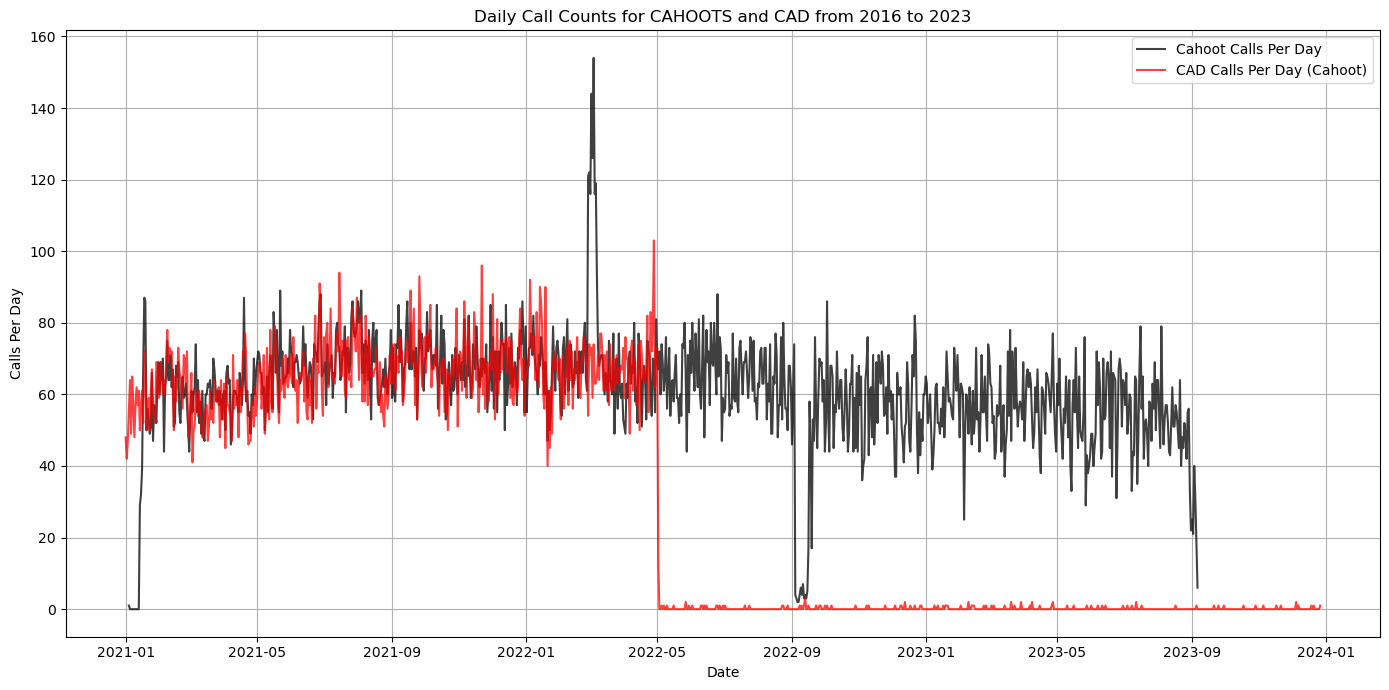

In [11]:
# Assuming cahootdf_copy and cahoot_in_cad16_23 are already defined
cahoots_copy2 = cahootdf_copy.copy()
cad_copy2 = cahoot_in_cad21_23.copy()

# Filter data for the period from 2016 to 2023
cahoots_copy2021 = cahoots_copy2[(cahoots_copy2['Datetime'] >= '2021-01-01') & (cahoots_copy2['Datetime'] <= '2023-12-31')]
cad_copy2021 = cad_copy2[(cad_copy2['Call_Created_Time'] >= '2021-01-01') & (cad_copy2['Call_Created_Time'] <= '2023-12-31')]

# Add CCPD columns
cahoots_copy2021['Date'] = cahoots_copy2021['Datetime'].dt.date
cad_copy2021['Date'] = cad_copy2021['Call_Created_Time'].dt.date

# Calculate calls per day
cahoots_daily_calls2021 = cahoots_copy2021.groupby('Date').size().reset_index(name='CCPD')
cad_daily_calls2021 = cad_copy2021.groupby('Date').size().reset_index(name='CCPD')

# Convert 'Date' back to datetime for resampling
cahoots_daily_calls2021['Date'] = pd.to_datetime(cahoots_daily_calls2021['Date'])
cad_daily_calls2021['Date'] = pd.to_datetime(cad_daily_calls2021['Date'])

# Resample to fill missing dates and set CCPD to 0 for missing dates
cahoots_daily_calls2 = cahoots_daily_calls2021.set_index('Date').resample('D').sum().fillna(0).reset_index()
cad_daily_calls2 = cad_daily_calls2021.set_index('Date').resample('D').sum().fillna(0).reset_index()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(cahoots_daily_calls2['Date'], cahoots_daily_calls2['CCPD'], label='Cahoot Calls Per Day', alpha=0.75, color='black')
plt.plot(cad_daily_calls2['Date'], cad_daily_calls2['CCPD'], label='CAD Calls Per Day (Cahoot)', alpha=0.75, color='red')
plt.title('Daily Call Counts for CAHOOTS and CAD from 2016 to 2023')
plt.xlabel('Date')
plt.ylabel('Calls Per Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the dataframes used for plotting
#print("CAHOOTS Daily Calls Dataframe:")
#print(cahoots_daily_calls.head())

#print("\nCAD Daily Calls Dataframe:")
#print(cad_daily_calls.head())

In [12]:
# Display the dataframes
#print("Cahoot Calls Per Day DataFrame:")
#cahootdf_copy2[['Date', 'CCPD']].drop_duplicates().head()
#print("\nCAD Calls Per Day DataFrame:")
#cahoot_in_cad21_23_copy[['Date', 'CCPD']].drop_duplicates().head()

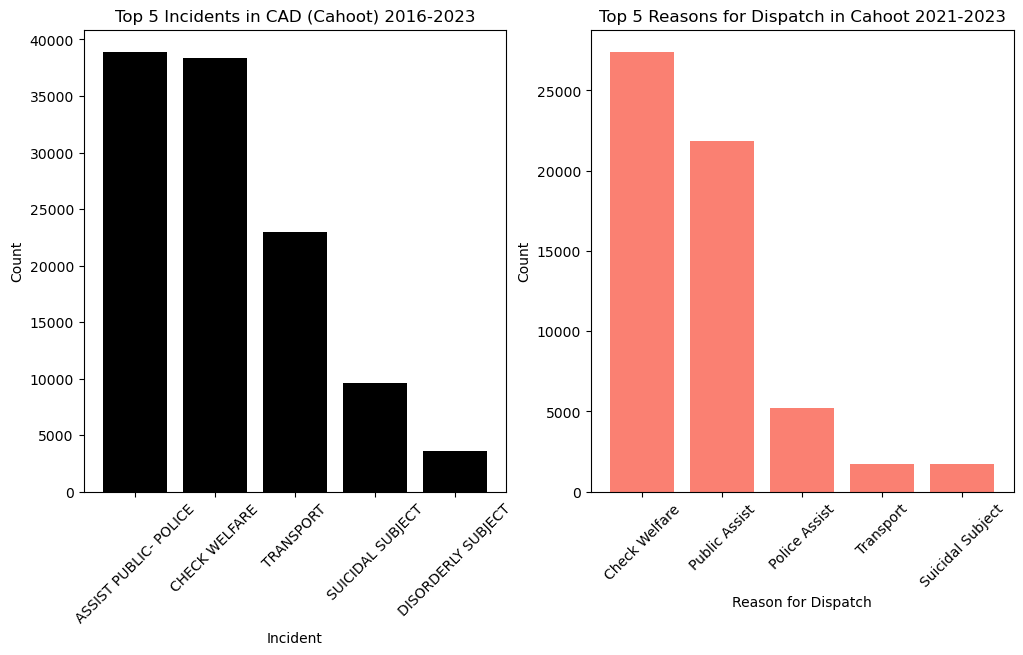

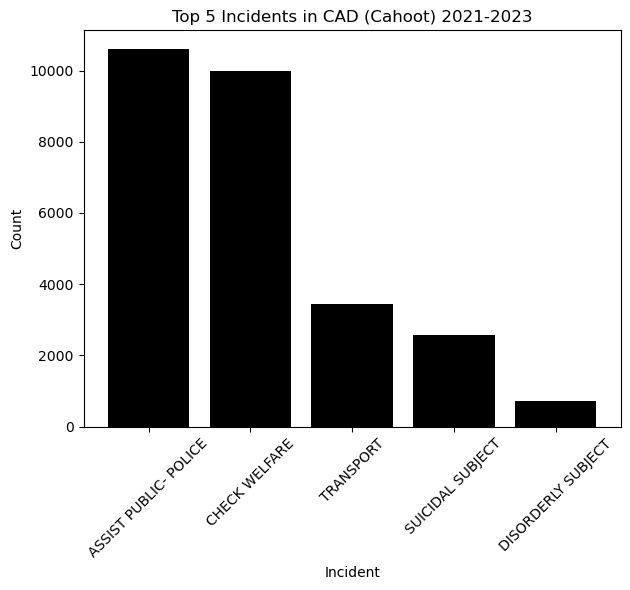

In [13]:
# Top 5 dispositions in CAD Cahoot dataframe
top_dispositions_cad = cahoot_in_cad16_23['InitialIncidentTypeDescription'].value_counts().head(5)

# Plot for CAD Cahoot dispositions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(top_dispositions_cad.index, top_dispositions_cad.values, color='black')
plt.title('Top 5 Incidents in CAD (Cahoot) 2016-2023')
plt.xlabel('Incident')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Top 5 reasons for dispatch in Cahoot dataframe
top_reasons_dispatch = cahootdf_copy['Reason for Dispatch'].value_counts().head(5)

# Plot for Cahoot dispatch reasons
plt.subplot(1, 2, 2)
plt.bar(top_reasons_dispatch.index, top_reasons_dispatch.values, color='salmon')
plt.title('Top 5 Reasons for Dispatch in Cahoot 2021-2023')
plt.xlabel('Reason for Dispatch')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Top 5 dispositions in CAD Cahoot dataframe (21-23)
top_dispositions_cad = cahoot_in_cad21_23['InitialIncidentTypeDescription'].value_counts().head(5)

# Plot for CAD Cahoot dispositions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(top_dispositions_cad.index, top_dispositions_cad.values, color='black')
plt.title('Top 5 Incidents in CAD (Cahoot) 2021-2023')
plt.xlabel('Incident')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [14]:
cahootdf_copy.dtypes

Datetime               datetime64[ns]
Age                            object
Gender                         object
Race                           object
City                           object
Reason for Dispatch            object
dtype: object

In [15]:
cahoot_in_cad21_23.dtypes

IncidentNumber                            object
Call_Created_Time                 datetime64[ns]
Call_Zipcode                             float64
InitialIncidentTypeDescription            object
Call_Priority                             object
IsPrimary                                  int64
PrimaryUnitCallSign                       object
RespondingUnitCallSign                    object
Unit_Dispatched_Time              datetime64[ns]
Disposition                               object
dtype: object